#### Detecção de Fraudes em Transações Financeiras

Notebook único contendo análise exploratória, feature engineering, modelagem e explicabilidade de um classificador binário para detecção de fraudes em transações de cartão de crédito.

In [64]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score



In [3]:
df = pd.read_csv("fraudTest.csv")

In [4]:
df.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

1. Quantas transações são fraude e quantas são corretas?

In [7]:
# Contagem absoluta de cada classe
contagem = df['is_fraud'].value_counts()

# Percentual de cada classe
percentual = df['is_fraud'].value_counts(normalize=True) * 100

# Exibir resultados
print("Contagem de transações:")
print(contagem)
print("\nPercentual de transações:")
print(percentual)

# Percentual isolado de fraudes
fraude_percentual = percentual.get(1, 0)
print(f"\nPercentual de transações fraudulentas: {fraude_percentual:.2f}%")

Contagem de transações:
is_fraud
0    553574
1      2145
Name: count, dtype: int64

Percentual de transações:
is_fraud
0    99.614014
1     0.385986
Name: proportion, dtype: float64

Percentual de transações fraudulentas: 0.39%


1. Qual o valor da perda financeira por fraudes?

In [9]:
# Total de valores por tipo de transação
valores_totais = df.groupby('is_fraud')['amt'].sum()

print(valores_totais)

# Se quiser formatar melhor:
total_normal = valores_totais.get(0, 0)
total_fraude = valores_totais.get(1, 0)

print(f"💳 Total de transações normais: R$ {total_normal:,.2f}")
print(f"⚠️ Total de transações fraudulentas: R$ {total_fraude:,.2f}")

is_fraud
0    37429578.43
1     1133324.68
Name: amt, dtype: float64
💳 Total de transações normais: R$ 37,429,578.43
⚠️ Total de transações fraudulentas: R$ 1,133,324.68


In [10]:
percent_fraude_valor = (total_fraude / (total_normal + total_fraude)) * 100
print(f"🚨 As fraudes representam {percent_fraude_valor:.3f}% do valor total movimentado.")

🚨 As fraudes representam 2.939% do valor total movimentado.


3. Em que período do dia ocorrem mais fraudes?

In [16]:
# Converter unix_time para datetime
df['transaction_time'] = pd.to_datetime(df['unix_time'], unit='s')

# Extrair hora do dia (0–23)
df['hora'] = df['transaction_time'].dt.hour

# Criar faixas de período do dia
def periodo_dia(h):
    if 0 <= h < 6:
        return 'madrugada'
    elif 6 <= h < 12:
        return 'manha'
    elif 12 <= h < 18:
        return 'tarde'
    else:
        return 'noite'

df['periodo_dia'] = df['hora'].apply(periodo_dia)


In [21]:
df[df['is_fraud'] == 1].groupby('periodo_dia').agg({
    'amt': 'sum',
    'trans_date_trans_time': 'count'
}).rename(columns = {
    'amt':'valor_total',
    'trans_date_trans_time': 'total_transacoes'
})

,valor_total,total_transacoes
periodo_dia,,
madrugada,277081.13,754
manha,30890.53,83
noite,764851.61,1205
tarde,60501.41,103


As transações fraudulentas costumam ocorrer em maior quantidade à noite e de madrugada.

In [22]:
df[df['is_fraud'] == 0].groupby('periodo_dia').agg({
    'amt': 'sum',
    'trans_date_trans_time': 'count'
}).rename(columns = {
    'amt':'valor_total',
    'trans_date_trans_time': 'total_transacoes'
})

,valor_total,total_transacoes
periodo_dia,,
madrugada,8180056.90,108191
manha,8211452.47,108297
noite,10405158.77,168095
tarde,10632910.29,168991


Como comparação, as transações normais ocorrem mais no período da tarde e da noite. 

4. Quais os valores em distribuição das transações fraudulentas e normais?

In [27]:
df.groupby('is_fraud')['amt'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,553574.0,67.614408,152.471931,1.00,9.60,47.15,82.62,22768.11
1,2145.0,528.356494,392.747594,1.78,214.51,371.94,907.77,1320.92


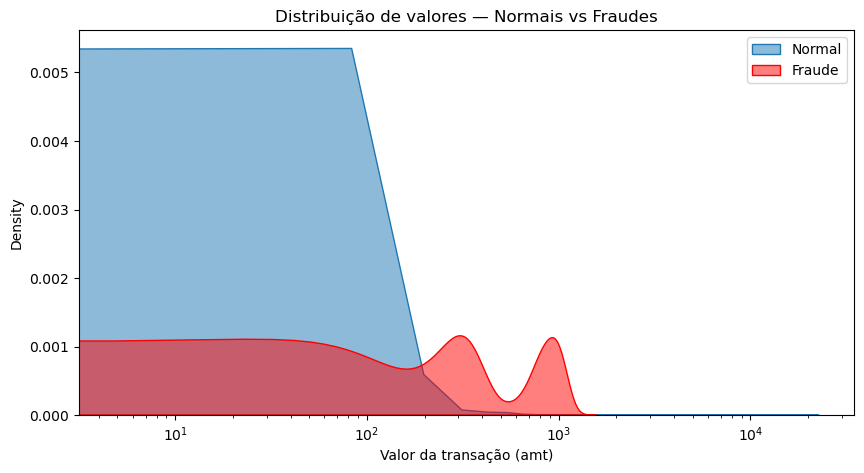

In [25]:
plt.figure(figsize=(10,5))
sns.kdeplot(df[df['is_fraud']==0]['amt'], label='Normal', fill=True, alpha=0.5)
sns.kdeplot(df[df['is_fraud']==1]['amt'], label='Fraude', fill=True, alpha=0.5, color='red')
plt.xscale('log')  # útil se houver valores muito altos
plt.xlabel('Valor da transação (amt)')
plt.title('Distribuição de valores — Normais vs Fraudes')
plt.legend()
plt.show()

Transações fraudulentas têm valor médio quase 8 vezes maior (R$ 528,36 vs R$ 67,61).

👉 Isso sugere que fraudadores preferem valores mais altos para maximizar ganho antes de detecção.

👉 As fraudes também têm maior variabilidade — valores muito distintos entre si, indicando que o padrão de gasto é menos previsível.

👉 Mesmo o valor mediano das fraudes é muito superior — a fraude típica envolve um valor que já seria considerado alto em compras legítimas.

5. Qual o padrão de distâncias das transações com fraude e normais?

In [28]:
# Função Haversine (distância em km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # raio da Terra em km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calcula a distância linha a linha
df['distancia_transacao'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])


In [29]:
df.groupby('is_fraud')['distancia_transacao'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,553574.0,76.104480,29.116533,0.123883,55.286175,78.178918,98.521159,150.922504
1,2145.0,76.213905,29.264066,3.839619,55.293105,78.593368,98.422515,142.849901


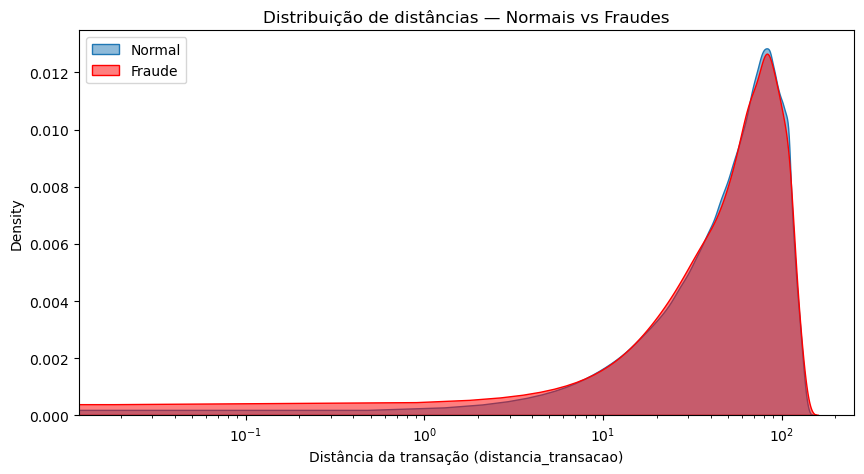

In [30]:
plt.figure(figsize=(10,5))
sns.kdeplot(df[df['is_fraud']==0]['distancia_transacao'], label='Normal', fill=True, alpha=0.5)
sns.kdeplot(df[df['is_fraud']==1]['distancia_transacao'], label='Fraude', fill=True, alpha=0.5, color='red')
plt.xscale('log')  # útil se houver valores muito altos
plt.xlabel('Distância da transação (distancia_transacao)')
plt.title('Distribuição de distâncias — Normais vs Fraudes')
plt.legend()
plt.show()

Distância não parece ser um fator discriminante direto neste caso.

👉 A variabilidade das distâncias é igual — tanto transações legítimas quanto fraudulentas ocorrem a distâncias semelhantes das residências.

👉 Nenhuma diferença relevante nas posições centrais.

👉 Pequenas variações aleatórias, sem padrão consistente.



6. Existe alguma correlação entre distância e valor das transações?

In [45]:
dist_fraude_distancia = df.loc[df['is_fraud'] == 1, 'distancia_transacao']
dist_normal_distancia = df.loc[df['is_fraud'] == 0, 'distancia_transacao']
dist_fraude_amt = df.loc[df['is_fraud'] == 1, 'amt']
dist_normal_amt = df.loc[df['is_fraud'] == 0, 'amt']

In [47]:
shapiro_fraude_dist = stats.shapiro(dist_fraude_distancia)
shapiro_normal_dist = stats.shapiro(dist_normal_distancia)
shapiro_fraude_amt = stats.shapiro(dist_fraude_amt)
shapiro_normal_amt = stats.shapiro(dist_normal_amt)

print("Distancia - Fraude - p-valor normalidade:", shapiro_fraude_dist.pvalue)
print("Distancia - Normal - p-valor normalidade:", shapiro_normal_dist.pvalue)

print("Valor - Fraude - p-valor normalidade:", shapiro_fraude_amt.pvalue)
print("Valor - Normal - p-valor normalidade:", shapiro_normal_amt.pvalue)

Distancia - Fraude - p-valor normalidade: 2.237026988400306e-13
Distancia - Normal - p-valor normalidade: 3.569019879357959e-89
Valor - Fraude - p-valor normalidade: 6.476791969170514e-37
Valor - Normal - p-valor normalidade: 4.597972050760124e-216


In [48]:
# Correlação entre valor e distância
pearson_r, pearson_p = stats.pearsonr(df['amt'], df['distancia_transacao'])
spearman_r, spearman_p = stats.spearmanr(df['amt'], df['distancia_transacao'])

print(f"Pearson: r = {pearson_r:.4f}, p = {pearson_p:.5f}")
print(f"Spearman: r = {spearman_r:.4f}, p = {spearman_p:.5f}")

Pearson: r = 0.0008, p = 0.56760
Spearman: r = 0.0000, p = 0.97257


In [ ]:
# Correlação entre valor e distância - com fraudes
pearson_r, pearson_p = stats.pearsonr(dist_fraude_distancia, dist_fraude_amt)
spearman_r, spearman_p = stats.spearmanr(dist_fraude_distancia, dist_fraude_amt)

print(f"Pearson: r = {pearson_r:.4f}, p = {pearson_p:.5f}")
print(f"Spearman: r = {spearman_r:.4f}, p = {spearman_p:.5f}")

Pearson: r = -0.0329, p = 0.12812
Spearman: r = -0.0256, p = 0.23514


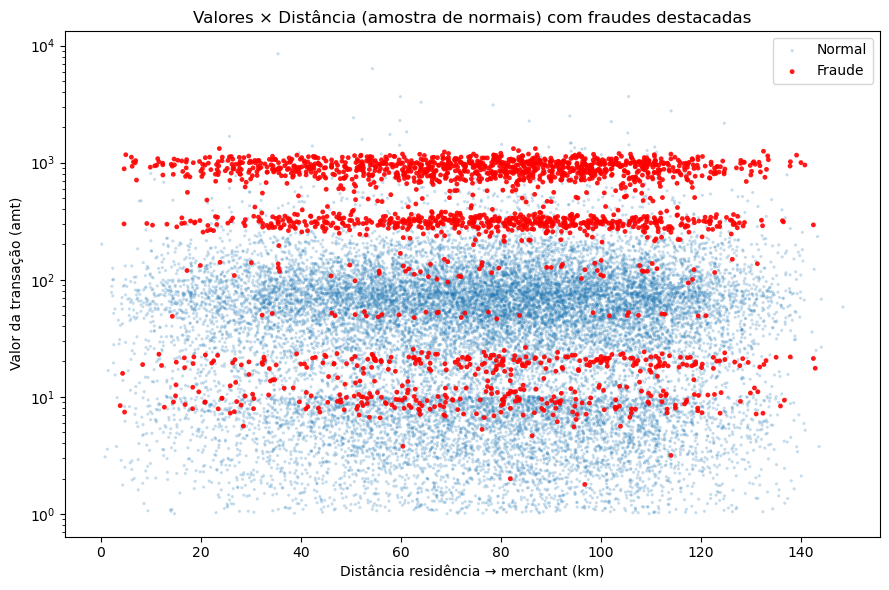

In [51]:
normais_sample = df[df['is_fraud']==0].sample(n=20000, random_state=42) if (df['is_fraud']==0).sum() > 20000 else df[df['is_fraud']==0]
fraudes = df[df['is_fraud']==1]

plt.figure(figsize=(9,6))

plt.scatter(
    normais_sample['distancia_transacao'], normais_sample['amt'],
    s=5, alpha=0.25, label='Normal', edgecolor='none'
)

plt.scatter(
    fraudes['distancia_transacao'], fraudes['amt'],
    s=12, alpha=0.9, label='Fraude', color='red', edgecolor='none'
)

plt.xlabel('Distância residência → merchant (km)')
plt.ylabel('Valor da transação (amt)')
plt.title('Valores × Distância (amostra de normais) com fraudes destacadas')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

Distância e valor são variáveis independentes no seu conjunto de dados.

Isso sugere que o comportamento de fraude (em relação ao valor) não depende da localização geográfica.

7. Quais as categorias das transações fraudulentas e não fraudulentas

In [55]:
df['category'].value_counts()

category
gas_transport     56370
grocery_pos       52553
home              52345
shopping_pos      49791
kids_pets         48692
shopping_net      41779
entertainment     40104
personal_care     39327
food_dining       39268
health_fitness    36674
misc_pos          34574
misc_net          27367
grocery_net       19426
travel            17449
Name: count, dtype: int64

In [57]:
fraude_por_categoria = (
    df.groupby('category')['is_fraud']
      .mean()
      .sort_values(ascending=False)
)

fraude_por_categoria

category
shopping_net      0.012111
misc_net          0.009756
grocery_pos       0.009229
shopping_pos      0.004278
gas_transport     0.002732
travel            0.002292
grocery_net       0.002111
misc_pos          0.002082
personal_care     0.001780
entertainment     0.001471
health_fitness    0.001418
food_dining       0.001375
kids_pets         0.001335
home              0.001280
Name: is_fraud, dtype: float64

C:\Users\pedrocnf\AppData\Local\Temp\ipykernel_3628\1623640680.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


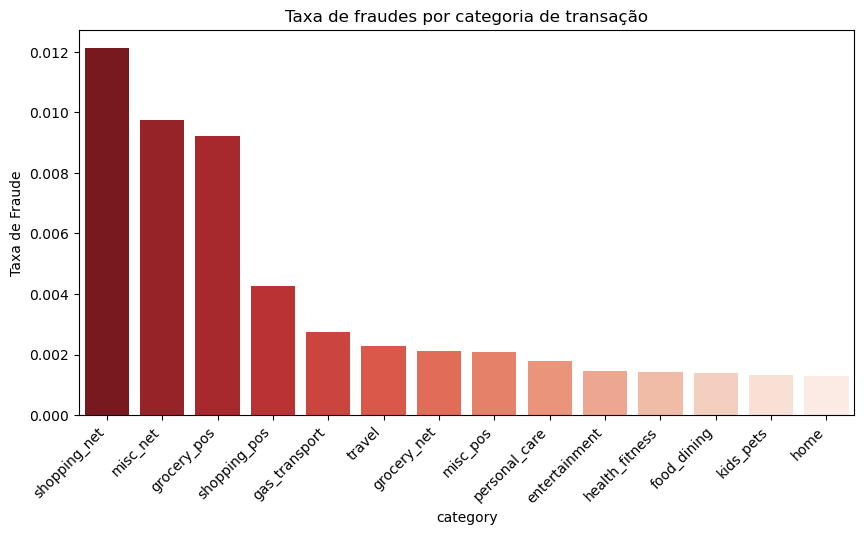

In [58]:
plt.figure(figsize=(10,5))
sns.barplot(
    x=fraude_por_categoria.index,
    y=fraude_por_categoria.values,
    palette='Reds_r'
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Taxa de Fraude')
plt.title('Taxa de fraudes por categoria de transação')
plt.show()

🔺 Categorias mais arriscadas

shopping_net (compras online) e misc_net (transações diversas online) aparecem no topo.

👉 Isso reflete um padrão global de fraude: transações não presenciais (online) são as mais vulneráveis, pois não há autenticação física do portador do cartão.

grocery_pos surpreende um pouco por estar em 3º lugar (0.92%), o que pode indicar:

falsos positivos em compras repetidas (uso legítimo detectado como suspeito); ou

uso de cartões clonados em mercados físicos, que são locais comuns para testes de cartões roubados.

⚖️ Categorias intermediárias

shopping_pos (lojas físicas) e gas_transport têm taxas mais baixas (~0.4% e 0.27%).

👉 Transações com presença física do cartão e/ou uso de chip tendem a ter menor risco.

🔻 Categorias de baixo risco

personal_care, health_fitness, food_dining, kids_pets, home estão abaixo de 0.2%.

👉 São setores com tíquetes baixos e transações locais — baixa atratividade para fraude.

Fraude online domina — categorias com _net no nome são mais vulneráveis.

Fraudes presenciais existem, mas geralmente com valores menores e podem servir de teste para validar cartões clonados.


In [59]:
df.groupby(['category', 'is_fraud'])['amt'].mean().unstack()

is_fraud,0,1
category,,
entertainment,63.328052,509.765593
food_dining,50.679363,122.361852
gas_transport,63.718286,12.002727
grocery_net,53.820633,11.668049
grocery_pos,114.048069,313.127258
health_fitness,53.915020,20.352308
home,57.739577,257.616418
kids_pets,57.557286,19.822308
misc_net,71.450544,804.280712


🔺 Categorias de alto risco (fraudes com ticket alto)

shopping_net, shopping_pos, misc_net, home, entertainment, grocery_pos
→ Fraudes muito mais caras que as transações normais.
Interpretação: fraude voltada a ganho financeiro imediato, compras de alto valor (e-commerce, eletrônicos, móveis, etc.).

⚖️ Categorias neutras ou mistas

food_dining, misc_pos
→ Fraudes de valor moderado, mas ainda acima do normal.
Interpretação: fraude “camuflada”, em estabelecimentos de rotina, tentando passar despercebida.

🔻 Categorias de baixo valor (fraudes pequenas)

gas_transport, grocery_net, kids_pets, health_fitness, personal_care, travel
→ Fraudes de valor muito menor que o ticket médio normal.
Interpretação:

Comportamento clássico de testes de cartão — o fraudador testa se o cartão clonado funciona com pequenas compras antes de fazer uma de alto valor.

Pode indicar fase inicial de ataque.

💬 Conclusão

As fraudes mais lucrativas concentram-se em categorias de compras (shopping_net, misc_net, home) — coerente com perfis reais de fraude.

As fraudes pequenas (grocery_net, gas_transport, travel) provavelmente são testes de viabilidade do cartão clonado.

Esse tipo de análise é muito útil para criar regras preditivas:

“Fraude provável se categoria = shopping_net e valor > 3× ticket médio da categoria”

“Fraude suspeita se categoria = gas_transport e valor < ¼ do ticket médio normal”

In [61]:


# --- Taxas de fraude ---
fraude_rate = {
    'shopping_net': 0.012111,
    'misc_net': 0.009756,
    'grocery_pos': 0.009229,
    'shopping_pos': 0.004278,
    'gas_transport': 0.002732,
    'travel': 0.002292,
    'grocery_net': 0.002111,
    'misc_pos': 0.002082,
    'personal_care': 0.001780,
    'entertainment': 0.001471,
    'health_fitness': 0.001418,
    'food_dining': 0.001375,
    'kids_pets': 0.001335,
    'home': 0.001280
}

# --- Ticket médio normal e fraude ---
ticket = {
    'entertainment': [63.33, 509.77],
    'food_dining': [50.68, 122.36],
    'gas_transport': [63.72, 12.00],
    'grocery_net': [53.82, 11.67],
    'grocery_pos': [114.05, 313.13],
    'health_fitness': [53.92, 20.35],
    'home': [57.74, 257.62],
    'kids_pets': [57.56, 19.82],
    'misc_net': [71.45, 804.28],
    'misc_pos': [61.91, 193.39],
    'personal_care': [48.27, 25.92],
    'shopping_net': [72.31, 994.32],
    'shopping_pos': [73.38, 886.79],
    'travel': [112.63, 8.70],
}

# Criar DataFrame
df_risco = pd.DataFrame(ticket, index=['ticket_normal', 'ticket_fraude']).T
df_risco['fraude_rate'] = pd.Series(fraude_rate)

# Calcular impacto médio da fraude
df_risco['impacto_relativo'] = df_risco['ticket_fraude'] / df_risco['ticket_normal']

# Criar uma pontuação de risco composta (0 a 100)
# Combina frequência e gravidade (ponderação 50/50)
df_risco['risco_score'] = (
    (df_risco['fraude_rate'] / df_risco['fraude_rate'].max()) * 50 +
    (df_risco['impacto_relativo'] / df_risco['impacto_relativo'].max()) * 50
)

# Ordenar da mais arriscada para a menos
df_risco = df_risco.sort_values('risco_score', ascending=False)

df_risco.round(3)


,ticket_normal,ticket_fraude,fraude_rate,impacto_relativo,risco_score
shopping_net,72.31,994.32,0.012,13.751,100.000
misc_net,71.45,804.28,0.010,11.257,81.208
shopping_pos,73.38,886.79,0.004,12.085,61.604
grocery_pos,114.05,313.13,0.009,2.746,48.085
entertainment,63.33,509.77,0.001,8.049,35.342
home,57.74,257.62,0.001,4.462,21.508
misc_pos,61.91,193.39,0.002,3.124,19.954
food_dining,50.68,122.36,0.001,2.414,14.456
gas_transport,63.72,12.00,0.003,0.188,11.964
travel,112.63,8.70,0.002,0.077,9.743


C:\Users\pedrocnf\AppData\Local\Temp\ipykernel_3628\2031062057.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


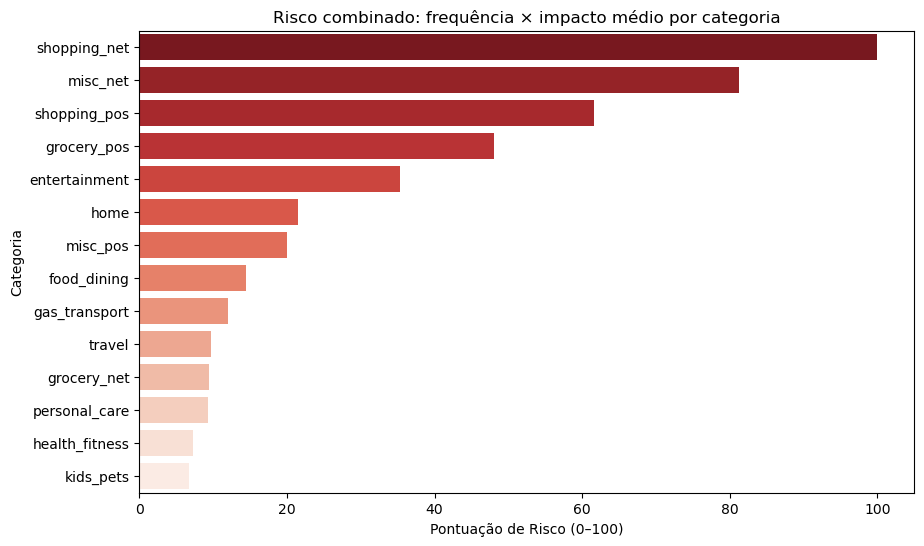

In [63]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_risco.reset_index(),
    x='risco_score', y='index',
    palette='Reds_r'
)
plt.xlabel('Pontuação de Risco (0–100)')
plt.ylabel('Categoria')
plt.title('Risco combinado: frequência × impacto médio por categoria')
plt.show()


💬 Conclusão:

Risco elevado: shopping_net, misc_net, shopping_pos — foco em monitoramento.

Risco médio: grocery_pos, home, entertainment.

Risco baixo (testes de cartão): gas_transport, grocery_net, travel.

8. Como classificar automaticamente uma transação como fraudulenta e não fraudulenta com segurança?

In [65]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'transaction_time', 'hora',
       'periodo_dia', 'distancia_transacao'],
      dtype='object')

In [73]:
# Features numéricas e categóricas
num_features = ['amt', 'distancia_transacao']
cat_features = ['category', 'periodo_dia']

In [74]:
# Variável alvo
target = 'is_fraud'

X = df[num_features + cat_features]
y = df[target]

In [75]:
# Pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

In [76]:
# Pipeline completo
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',  # importante em datasets desbalanceados
        random_state=42
    ))
])

In [77]:
# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [78]:
# Treinar
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt',
                                                   'distancia_transacao']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['category',
                                                   'periodo_dia'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=200, random_state=42))])

In [79]:
# Previsões
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # probabilidade de fraude

# Avaliar
print("=== Relatório de Classificação ===")
print(classification_report(y_test, y_pred, digits=3))
print("=== Matriz de Confusão ===")
print(confusion_matrix(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

=== Relatório de Classificação ===
              precision    recall  f1-score   support

           0      1.000     0.983     0.991    166072
           1      0.168     0.901     0.283       644

    accuracy                          0.982    166716
   macro avg      0.584     0.942     0.637    166716
weighted avg      0.996     0.982     0.988    166716

=== Matriz de Confusão ===
[[163203   2869]
 [    64    580]]
AUC-ROC: 0.9869495306458412


🧠 Interpretação prática

✅ O modelo é ótimo para detectar fraudes reais

Ele encontra a maioria das fraudes (recall 90%), o que é essencial em detecção de fraude, onde perder uma fraude é pior do que gerar um falso alerta.

⚠️ Mas precisa melhorar a precisão

Apenas 17% das previsões de fraude realmente são fraudes → alto custo operacional (muitos falsos positivos).

Isso é comum porque a classe “fraude” representa <1% dos dados, e o modelo está tentando compensar o desbalanceamento.

🧩 O que a matriz de confusão mostra
[[163203   2869]   → normais bem classificados / falsos positivos
 [    64    580]]  → fraudes perdidas / fraudes corretas


2869 falsos positivos (transações legítimas marcadas como fraude).

64 falsos negativos (fraudes não detectadas).
👉 excelente cobertura, mas ainda agressivo nas previsões de fraude.

In [80]:
# Pegar nomes após o one-hot encoding
feature_names = (
    num_features +
    list(model.named_steps['preprocess']
         .named_transformers_['cat']
         .get_feature_names_out(cat_features))
)

importances = model.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print(feat_imp.head(10))

amt                       0.673982
periodo_dia_tarde         0.071086
periodo_dia_manha         0.037102
periodo_dia_noite         0.031625
category_shopping_net     0.028023
distancia_transacao       0.025143
periodo_dia_madrugada     0.023296
category_grocery_pos      0.020226
category_gas_transport    0.018267
category_misc_net         0.010821
dtype: float64


O modelo aprendeu que fraudes são mais relacionadas ao valor e contexto temporal do que à distância.

Isso confirma empiricamente o que você já descobriu nos testes de correlação:

Distância tem pouca relação direta.

Valor (amt) domina o comportamento.

As categorias online (shopping_net, misc_net) e horários atípicos (noite/madrugada) reforçam o risco.

In [86]:
nova_transacao = pd.DataFrame([{
    'amt': 850.0,
    'distancia_transacao': 78.2,
    'category': 'shopping_net',
    'periodo_dia': 'Noite'
}])

prob = model.predict_proba(nova_transacao)[0, 1]
print(f"Probabilidade de fraude: {prob*100:.2f}%")

Probabilidade de fraude: 76.66%
